In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43207")
client

<Client: 'tcp://127.0.0.1:43207' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:40369' processes=7 threads=56, memory=206.47 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
fesom01w = cat.FESOM(datatype='int', season='fma').to_dask().chunk({'depth':6,'lat':100,'lon':100})
# fesom01s = cat.FESOM(datatype='int', season='aso').to_dask().chunk({'depth':8})
fesom01w

,Array,Chunk
Bytes,16.09 GiB,2.29 MiB
Shape,"(90, 48, 1000, 1000)","(10, 6, 100, 100)"
Count,14410 Tasks,7200 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.09 GiB,2.29 MiB
Shape,"(90, 48, 1000, 1000)","(10, 6, 100, 100)"
Count,14410 Tasks,7200 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
mask = xr.DataArray(np.ma.masked_invalid(fesom01w.salt.where(fesom01w.salt>32.).where(fesom01w.salt<38.)
                                        ).mask,
                    dims=fesom01w.salt.dims, coords=fesom01w.salt.coords
                   ).chunk({'depth':6,'lat':100,'lon':100}).mean('time',skipna=True)
mask = xr.DataArray(np.ma.masked_invalid(mask.where(mask==1.)).mask,
                    dims=fesom01w.salt.isel(time=0).dims, coords=fesom01w.salt.isel(time=0).coords
                   )

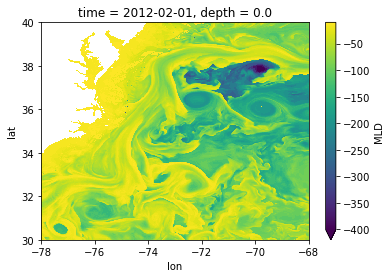

In [8]:
grav = 9.81
w_path = f'{SCRATCH}/region01/FESOM/'+f'sigma0_fma.zarr' 

sig0win = xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(mask!=0.)
        
sig0win.coords['time'] = fesom01w.time

bw = -sig0win.chunk({'lat':-1,'lon':-1}) * grav / 1e3
bw.coords['time'] = fesom01w.time

MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLD_fma.zarr")
                   ).MLD.where(mask.isel(depth=0)!=0.).chunk({'lat':100,'lon':100})
MLDw.isel(time=0).plot(vmin=-400)

In [9]:
import gsw
xx, yy = np.meshgrid(fesom01w.lon, 
                     fesom01w.lat
                    )
ny, nx = xx.shape
dx = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                               coords={'lat':np.arange(ny),'lon':np.arange(.5,nx-1,1)}
                              ).interp(lon=np.arange(nx), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )
dy = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                               coords={'lat':np.arange(.5,ny-1,1),'lon':np.arange(nx)}
                              ).interp(lat=np.arange(ny), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )
dx

<xarray.DataArray (lat: 1000, lon: 1000)>
array([[963.9402524 , 963.94025241, 963.94025241, ..., 963.94025241,
        963.94025241, 963.94025241],
       [963.84300745, 963.84300745, 963.84300745, ..., 963.84300745,
        963.84300745, 963.84300745],
       [963.74573308, 963.74573308, 963.74573308, ..., 963.74573308,
        963.74573308, 963.74573308],
       ...,
       [852.90515288, 852.90515288, 852.90515288, ..., 852.90515288,
        852.90515288, 852.90515288],
       [852.78019513, 852.78019513, 852.78019513, ..., 852.78019513,
        852.78019513, 852.78019513],
       [852.65521135, 852.65521135, 852.65521135, ..., 852.65521135,
        852.65521135, 852.65521135]])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0

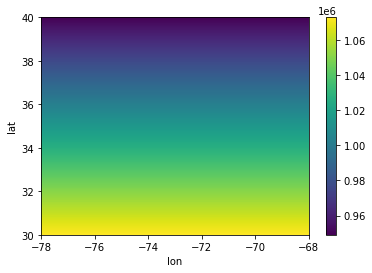

In [10]:
area = (dx * dy)
area.plot()

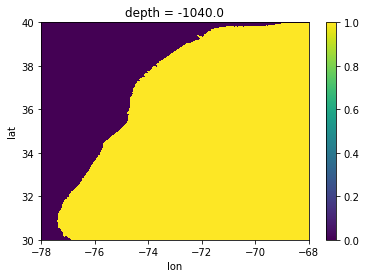

In [11]:
wet_mask = xr.DataArray(np.zeros_like(fesom01w.salt.isel(time=0)),
                        dims=['depth','lat','lon'],
                        coords={'depth':fesom01w.depth,
                                'lat':fesom01w.lat.data,
                                'lon':fesom01w.lon.data}
           )
wet_mask[:,1:-1,1:-1] = (mask.isel(lat=slice(1,-1),lon=slice(1,-1)).data).astype(np.float64)
wet_mask.isel(depth=-1).plot()

In [12]:
dlat = fesom01w.lat.diff('lat')[0]
dlon = fesom01w.lon.diff('lon')[0]

dxw = xr.DataArray(dx.interp(lon=np.arange(dx.lon.min()-dlon,dx.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dy.interp(lon=np.arange(dy.lon.min()-dlon,dy.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dx.interp(lat=np.arange(dx.lat.min()-dlat,dx.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dy.interp(lat=np.arange(dy.lat.min()-dlat,dy.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray (lat: 1000, lon: 1000)>
array([[963.9402524 , 963.9402524 , 963.94025241, ..., 963.94025241,
        963.94025241, 963.94025241],
       [963.84300745, 963.84300745, 963.84300745, ..., 963.84300745,
        963.84300745, 963.84300745],
       [963.74573308, 963.74573308, 963.74573308, ..., 963.74573308,
        963.74573308, 963.74573308],
       ...,
       [852.90515287, 852.90515288, 852.90515288, ..., 852.90515288,
        852.90515288, 852.90515288],
       [852.78019513, 852.78019513, 852.78019513, ..., 852.78019513,
        852.78019513, 852.78019513],
       [852.65521135, 852.65521135, 852.65521135, ..., 852.65521135,
        852.65521135, 852.65521135]])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0

In [13]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(852.65521135)

In [14]:
kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

In [17]:
filter_scale = 30000   # 30 km
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'lat':-1,'lon':-1}), 
        'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
        'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
        'area': area.chunk({'lat':-1,'lon':-1}), 
        'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
    }
)
filter_30km

Filter(filter_scale=30000, dx_min=array(852.65521135), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=39, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [15]:
At = area.isel(lat=slice(1,-1),lon=slice(1,-1))

ncoars = 7

In [16]:
MLDw_coar = ((MLDw.isel(lat=slice(1,-1),lon=slice(1,-1))
              *At).coarsen({'lat':ncoars,'lon':ncoars},boundary='trim').sum(skipna=True)
             * At.coarsen({'lat':ncoars,'lon':ncoars},boundary='trim').sum(skipna=True)**-1
            )
MLDw_coar

<xarray.DataArray (time: 90, lat: 142, lon: 142)>
dask.array<mul, shape=(90, 142, 142), dtype=float64, chunksize=(90, 15, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.04 30.11 30.18 30.25 ... 39.71 39.78 39.85 39.92
  * lon      (lon) float64 -77.96 -77.89 -77.82 -77.75 ... -68.22 -68.15 -68.08
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30
    depth    float64 0.0

In [19]:
Zl = .5*(fesom01w.depth[1:].data+fesom01w.depth[:-1].data)
dZl = np.abs(np.diff(Zl))
dzs = np.concatenate((np.concatenate((np.array([.5*np.abs(fesom01w.depth[1].data)]),dZl)),
                      np.array([.5*np.abs(fesom01w.depth[-1].data)])))
xrdzs = xr.DataArray(dzs, dims='depth', coords={'depth':fesom01w.depth})
xrdzs

<xarray.DataArray (depth: 48)>
array([  2.5,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,
         5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,
         5. ,   5. ,   7.5,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,
        10. ,  10. ,  10. ,  15. ,  20. ,  20. ,  20. ,  20. ,  30. ,
        40. ,  40. ,  40. ,  40. ,  40. ,  40. ,  40. ,  40. ,  70. ,
       100. , 140. , 520. ])
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03

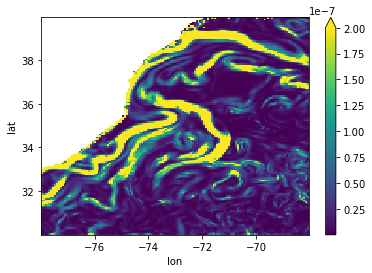

gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_45.zarr
45
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_46.zarr
46
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_47.zarr
47
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_48.zarr
48
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_49.zarr
49
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_50.zarr
50
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_51.zarr
51
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_52.zarr
52
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_53.zarr
53
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_54.zarr
54
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_55.zarr
55
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_56.zarr
56
gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLI-30km_z0-MLD_fma_57.zarr
57

In [23]:
istart = 45

for i in range(istart,len(fesom01w.time)):
    bm = filter_30km.apply(bw.isel(time=i).chunk({'lat':-1,'lon':-1}), dims=['lat','lon']
                          ).chunk({'lat':100,'lon':100})
    bmx = (bm.isel(lon=slice(1,None)).data
           + bm.isel(lon=slice(None,-1))
          ) * .5
    bmy = (bm.isel(lat=slice(1,None)).data
           + bm.isel(lat=slice(None,-1))
          ) * .5
    dbmx = bmx.diff(dim='lon') * dx.isel(lon=slice(1,-1))**-1
    dbmy = bmy.diff(dim='lat') * dy.isel(lat=slice(1,-1))**-1
    
    M2 = np.sqrt(dbmx.isel(lat=slice(1,-1))**2 + dbmy.isel(lon=slice(1,-1))**2).chunk({'lat':100,'lon':100})
    
    M2_coar = ((M2.where(M2.depth>=MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)))
                * At).coarsen({'lat':ncoars,'lon':ncoars}, boundary='trim').sum(skipna=True)
               * At.coarsen({'lat':ncoars,'lon':ncoars}, boundary='trim').sum(skipna=True)**-1
              )
    
    M2_coarH = (M2_coar 
                * xr.DataArray(xrdzs.where(xrdzs.depth>=MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))
                                          ).coarsen({'lat':ncoars,'lon':ncoars},
                                                    boundary='trim').mean(skipna=True).transpose('depth','lat','lon').data,
                               dims=M2_coar.dims, coords=M2_coar.coords)
               ).sum('depth', skipna=True)
    
    if i == istart:
        import gsw
        f = xr.DataArray(gsw.f(fesom01w.lat.isel(lat=slice(1,-1)).coarsen({'lat':ncoars},
                                                                          boundary='trim').mean(skipna=True)
                              ).data, 
                         dims='lat', coords={'lat':M2_coar.lat})
        lat_coar = fesom01w.lat.isel(lat=slice(1,-1)).coarsen({'lat':ncoars},
                                                              boundary='trim').mean(skipna=True).reset_coords(drop=True)
        lon_coar = fesom01w.lon.isel(lon=slice(1,-1)).coarsen({'lon':ncoars},
                                                              boundary='trim').mean(skipna=True).reset_coords(drop=True)
    
    MLI = xr.DataArray((M2_coarH**2 
                       / f).where(xr.DataArray(mask.sel(depth=-1e2, method='nearest'
                                                       ).isel(lat=slice(1,-1),
                                                              lon=slice(1,-1)
                                                             ).coarsen({'lat':ncoars,'lon':ncoars},
                                                                       boundary='trim').mean(skipna=True).data,
                                               dims=M2_coarH.dims, coords=M2_coarH.coords
                                              )!=0.
                                 ).reset_coords(drop=True),
                       dims=['lat','lon'], coords={'lat':lat_coar,'lon':lon_coar}
                      ).chunk({'lat':80,'lon':80})
    if i == istart:
        MLI.plot(vmax=2e-7)
        plt.show()
        
    tmp_path = f'{SCRATCH}/region01/FESOM/'+f'MLI-30km_z0-MLD_fma_%02d.zarr' % i 
    print(tmp_path)
    store_tmp = gcs.get_mapper(tmp_path)
    MLI.to_dataset(name='MLI').to_zarr(store_tmp, mode='w')
        
    print(i)

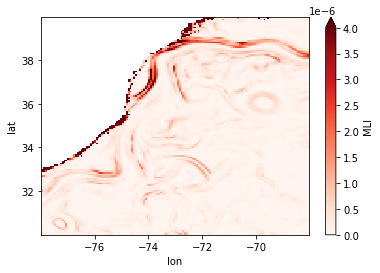

In [18]:
for i in range(len(fesom01w.time)):
    tmp_path = f'{SCRATCH}/region01/FESOM/'+f'MLI-30km_z0-MLD_fma_%02d.zarr' % i 
    if i == 0:
        MLI = xr.open_zarr(gcs.get_mapper(tmp_path)).MLI
    else:
        MLI = xr.concat([MLI, xr.open_zarr(gcs.get_mapper(tmp_path)).MLI
                        ], 'time')
MLI.isel(time=0).plot(cmap='Reds', vmin=0, vmax=4e-6)

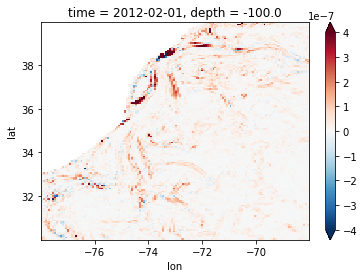

In [17]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/wb-30km_z0-MLD_fma.zarr")
                   ).wpbp
wpbp_coar = ((wpbp * At).coarsen({'lat':ncoars,'lon':ncoars},
                                                                  boundary='trim').sum(skipna=True)
             * At.coarsen({'lat':ncoars,'lon':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            ).where(mask.sel(depth=-1e2, method='nearest'
                            ).isel(lat=slice(1,-1),lon=slice(1,-1)
                                  ).coarsen({'lat':ncoars,'lon':ncoars},
                                            boundary='trim').mean(skipna=True)!=0.
                   )
wpbp_coar.isel(time=0).plot(cmap='RdBu_r', vmin=-4e-7, vmax=4e-7)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


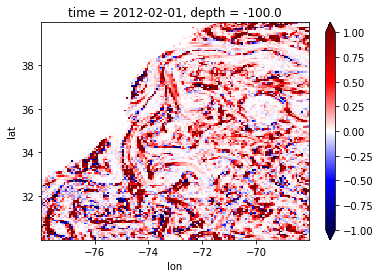

In [19]:
(wpbp_coar / MLI).isel(time=0).plot(vmax=1, cmap='seismic')

In [20]:
alpha = (wpbp_coar / MLI).median(['lat','lon'],skipna=True).compute()

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar.name = 'wpbp'

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


In [21]:
time = np.arange('2012-02', '2012-05', dtype='datetime64[D]')
time

array(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04',
       '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
       '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12',
       '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16',
       '2012-02-17', '2012-02-18', '2012-02-19', '2012-02-20',
       '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24',
       '2012-02-25', '2012-02-26', '2012-02-27', '2012-02-28',
       '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03',
       '2012-03-04', '2012-03-05', '2012-03-06', '2012-03-07',
       '2012-03-08', '2012-03-09', '2012-03-10', '2012-03-11',
       '2012-03-12', '2012-03-13', '2012-03-14', '2012-03-15',
       '2012-03-16', '2012-03-17', '2012-03-18', '2012-03-19',
       '2012-03-20', '2012-03-21', '2012-03-22', '2012-03-23',
       '2012-03-24', '2012-03-25', '2012-03-26', '2012-03-27',
       '2012-03-28', '2012-03-29', '2012-03-30', '2012-03-31',
       '2012-04-01', '2012-04-02', '2012-04-03', '2012-

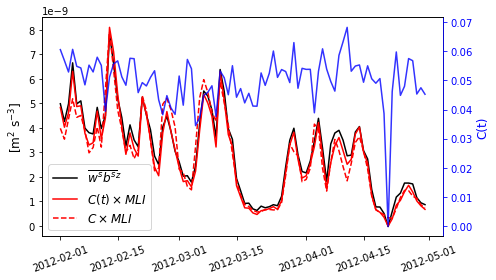

In [22]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['lat','lon'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['lat','lon'],skipna=True), c='r', label=r'$C(t) \times MLI$')
ax.plot(time, (alpha.mean('time')*MLI).median(['lat','lon'],skipna=True), c='r', ls='--', label=r'$C \times MLI$')

ax2.plot(time, alpha, c='b', alpha=.8)

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2012-02-01','2012-02-15','2012-03-01','2012-03-15','2012-04-01','2012-04-15','2012-05-01'])
ax.set_xticklabels(labels=['2012-02-01','2012-02-15','2012-03-01','2012-03-15','2012-04-01','2012-04-15','2012-05-01'],
                   rotation=20)
ax2.set_ylabel(r"C(t)", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/FESOM-wb-timeseries_01.pdf')

In [29]:
mask0 = mask.isel(depth=0,lat=slice(1,-1),lon=slice(1,-1)).coarsen({'lat':ncoars,'lon':ncoars},
                                                          boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask0 = ~np.ma.masked_values(mask0,0).mask
mask0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

/tmp/ipykernel_1561/1510303537.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(MLI.lon, MLI.lat, wpbp_coar.isel(time=0),
/tmp/ipykernel_1561/1510303537.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(MLI.lon, MLI.lat, aMLI.isel(time=0),
/tmp/ipykernel_1561/1510303537.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corn

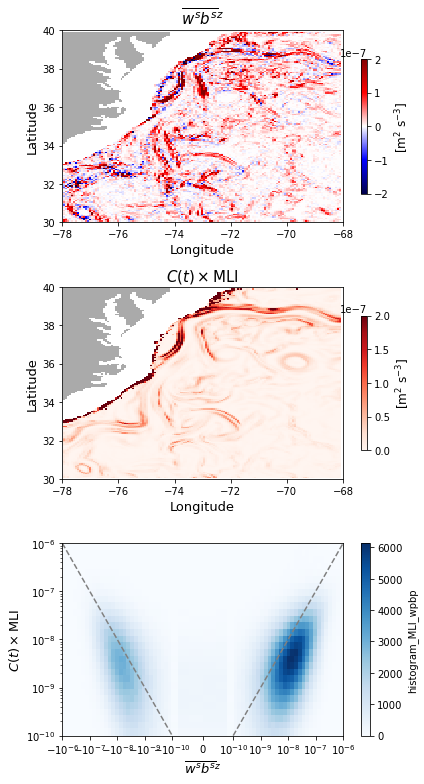

In [32]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,11),nrows=3,ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(MLI.lon, MLI.lat, wpbp_coar.isel(time=0),
                     vmin=-2e-7, vmax=2e-7, cmap='seismic', rasterized=True)
im2 = ax2.pcolormesh(MLI.lon, MLI.lat, aMLI.isel(time=0),
                     vmin=0., vmax=2e-7, cmap='Reds', rasterized=True)

ax1.pcolormesh(MLI.lon, MLI.lat, 
               np.ma.masked_array(mask0, mask0),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(MLI.lon, MLI.lat, 
               np.ma.masked_array(mask0, mask0),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

xhist((aMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthresh=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax3.set_ylabel(r"$C(t)\times$MLI", fontsize=13)
ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_title(r"$C(t)\times$MLI", fontsize=15)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM-wb-hist_01.pdf')